In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd

def crop_save(in_dir, in_file, out_dir,crop_dim):
    ncInFile = os.path.join(in_dir, in_file+'.nc')
    ds = xr.open_dataset(ncInFile)
    
    # take a slice of the variable with the name supplied by crop_dim
    ds = ds.sel(**{crop_dim: slice('2024-12-19 12:00', '2024-12-20')})
    #ds = ds.sel(t=slice('2024-12-19 12:00', '2024-12-20'))

    encoding = {var: {"zlib": True, "complevel": 4} for var in list(ds.data_vars) + list(ds.coords)}  # Apply deflate compression to all variables and coordinates in netCDF
    ds.to_netcdf(os.path.join(out_dir, in_file+' crop.nc'), encoding=encoding) # save to netcdf

In [ ]:
# Load, export pressure data
out_dir = r'O:\HybridDune experiment\collection Murat'
in_dir = r'O:\HybridDune experiment\data RBR, OSSI\copy RBR Udrive series1\raw NetCDF'
in_file = r'refP1 RBR4 raw data - period 1'
crop_save(in_dir, in_file, out_dir,'t')

in_dir = r'O:\HybridDune experiment\data RBR, OSSI\copy RBR Udrive series1\processed'
in_file = r'Pressure sensor S3P3 RBR6 processed data - period 1'
#crop_save(in_dir, in_file, out_dir,'t_full')

in_dir = r'O:\HybridDune experiment\data RBR, OSSI\Ossi data\processed'
in_file = 'Pressure sensor S3P1 Ossi6 processed data - period 1'
crop_save(in_dir, in_file, out_dir,'t_full')

in_file = 'Pressure sensor S3P2 Ossi2 processed data - period 1'
crop_save(in_dir, in_file, out_dir,'t_full')

In [24]:
# Load, export ADV data
in_dir = r'O:\HybridDune experiment\data ADV, OBS\raw NetCDF'
in_file = 'ADV_RWS3_Deployment1'
# crop_save(in_dir, in_file, out_dir,'t')

in_dir = r'O:\HybridDune experiment\data ADV, OBS\processed'
in_file = 'Processed data S3_ADV1'
# crop_save(in_dir, in_file, out_dir,'t')

in_dir = r'O:\HybridDune experiment\data ADV, OBS\QC'
in_file = 'QC_ADV_RWS3_Deployment1'
crop_save(in_dir, in_file, out_dir,'t')

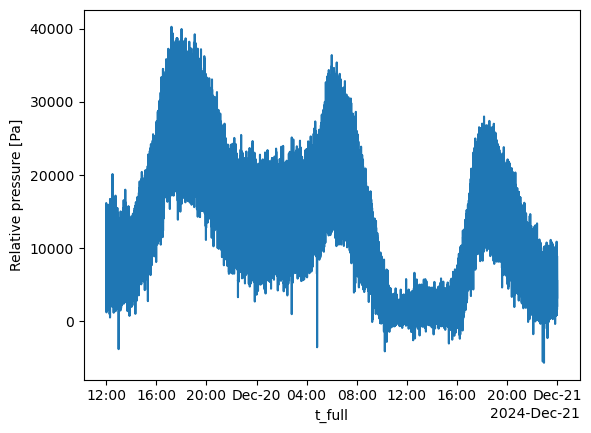

In [ ]:
# plot the pressure data
ds['p'].plot()

# set x limits from 19 dec 12:00 to 20 december 2024
#ds['p'].sel(t_full=slice('2024-12-19 12:00', '2024-12-20')).plot()

In [ ]:
out_dir = r'O:\HybridDune experiment\collection Murat'
in_dir = r'O:\HybridDune experiment\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1'
in_file = 'storm1_lidar1_10sInterval - Copy'

ncInFile = os.path.join(in_dir, in_file+'.nc')
ds = xr.open_dataset(ncInFile)
ds = ds.assign_coords(time=("time", ds["time_num"].values))   # Set the values in 'time_num' as coordinate for the dimension 'time'
ds = ds.drop_vars("time_num")
ds = ds.sel(time=slice('2024-12-19 12:00', '2024-12-20'))
ds = ds.assign_coords(profile_number=("profile_number", range(1,17)))   # set profile numbers from 1 to 16
ds = ds.sel(profile_number=slice(3,3))  # Select profile number 3

encoding = {var: {"zlib": True, "complevel": 4, 'shuffle': False} for var in list(ds.data_vars) + list(ds.coords)}  # Apply deflate compression to all variables and coordinates in netCDF
ds.to_netcdf(os.path.join(out_dir, in_file+' crop no_shuffle.nc'), encoding=encoding) # save to netcdf

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


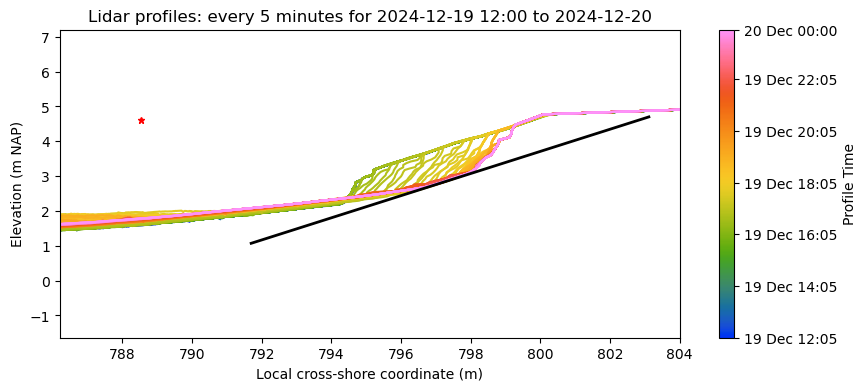

In [6]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import colorcet as cc   # For color maps

in_dir = r'O:\HybridDune experiment\collection Murat'
in_file = r'lidar data S1 storm 1 - 5 minute profiles.nc'

ncInFile = os.path.join(in_dir, in_file)
ds = xr.open_dataset(ncInFile)

x = ds.x_obs.values
z = ds.z_obs.values
times = ds.t.values


plt.figure(figsize=(10, 4))

num_profiles = x.shape[0]
cmap = plt.get_cmap('cet_CET_R1')
norm = Normalize(vmin=0, vmax=num_profiles - 1)

# plot 1 line for every profile, i.e. 1 line for every row from 2D array x, z
for i in range(num_profiles):
    color = cmap(norm(i))
    mask = ~np.isnan(x[i, :]) & ~np.isnan(z[i, :])
    plt.plot(x[i, mask], z[i, mask], color=color, label=f'Profile {i+1}')

# plot the lidar and revetment
plt.plot(ds.x_constructions,ds.z_constructions, color='black', linewidth=2, label='Revetment')
plt.plot(ds.x_sensor, ds.z_sensor, color='red', marker='*', markersize=5, label='Lidar')

# Create a ScalarMappable with the same norm and cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for matplotlib < 3.1

# Choose tick positions (e.g., first, middle, last)
tick_indices = list(range(0, num_profiles, num_profiles // 6)) + [num_profiles - 1]  # One label for every sixth of the dataset, so every 2 hours
tick_labels = [pd.to_datetime(times[i]).strftime('%d %b %H:%M') for i in tick_indices] 

cbar = plt.colorbar(sm, ax=plt.gca(), label='Profile Time')
cbar.set_ticks(tick_indices)
cbar.set_ticklabels(tick_labels)

# Figure formatting
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlim(786.2, 804)
plt.ylim(np.nanmin(z), np.nanmax(z))  # Or set to your desired y-range

plt.xlabel('Local cross-shore coordinate (m)')
plt.ylabel('Elevation (m NAP)')
plt.title('Lidar profiles: every 5 minutes for 2024-12-19 12:00 to 2024-12-20')
plt.show()
ds.close()